In [1]:
#-*-coding:utf-*-

from pyspark import SparkContext, SparkConf 
from pyspark.sql import SQLContext, Row 
import json 

conf   = SparkConf().setAppName("Graph")
sc     = SparkContext(conf = conf)
sqlCtx = SQLContext(sc)
print "Loading data from ./data"
jsons  = sqlCtx.read.json("./data")
jsons.registerTempTable("malwares")
mal    = sqlCtx.sql("SELECT pe_imphash FROM malwares")

Loading data from ./data


In [9]:
list = mal.collect()
for l in list:
    print l['pe_imphash']

6168179f47d817f67fd0d01c64e6aada
59e03b48c9d2867825f9d3e79edd8b69
65e1a1270505c6e788e893624c9265fa
6796132c42f0748def65d2c190e9ecc8
24e8415093488ae58a5438b98d04384e
6c070eca42a787e47a50768d367386cc
3a71fef21709850658f4bdfd084f9d08
3a71fef21709850658f4bdfd084f9d08
3a71fef21709850658f4bdfd084f9d08
63c761a55a6d9cb7540ddab522053417
9581f3517c6ec98527a12c40a721c063
0dc55f64d9578dafbcec0f9ac57346c7
28b834bfdb1c2e3b8de30039f1e0a8b0
59ce2a9f5c027c9e6fd6785d669563cf
d03ea8402fe5aac4368edd3aa718bd7d
b2d501a9407373c0d9ad9782452ba920
03bfe9512023159bab865782d92b00d4
d6066fec3aca41585c3fd4d536d62c1c
1c23e8c9f757a774def0aba6c9eb8cdd
c702a2eef9cf81102a9166cc62905b24
ad90b6a413f64e5a0608c2f793086bee
4cbaafd18ff55776e15348dcf134fe89
6dbcb2852a3df210728dd0c31f635ef8
94efe70ed9c385ff1fc11d82e0fb8aff
94efe70ed9c385ff1fc11d82e0fb8aff
b752954037d9b01b10538cce7cc81d82
afd6d9baac198c579ab9b14a9b0127b8
49a6f83760385b33b5fc4f695991c24f
424371837915f6a8f80056531ef1b442
d7f72c6755c7886bdd44934f242bdfa7
21014d77b1

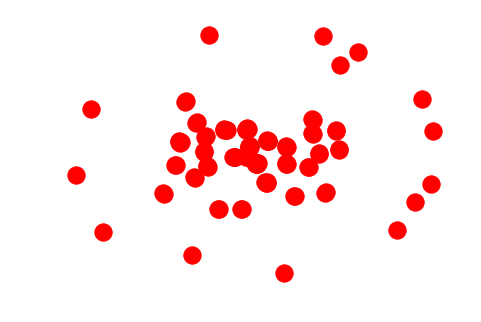

Subgraph 4 has 11 nodes [u'243f2099425454f11a759eee75a0069929e2cfd8', u'36b11b6e0d082e51c2be7a9b553e7011a56eb4d1', u'0217c26baf4794a019c962e1e2e490410bc033a0', u'8c86ecae063148e991c65b8302204b58445ba500', u'fa71d38877c6f2138cb7b458f99d1ec74c874fc7', u'f6d239ee6b6f454eaab8eb4be0372f8367cb0560', u'380116dd476e388999c3835e347a160780883799', u'90474af4f36991af46094b421ca91c5b610466bb', u'9bd68555d4f0387daf7dd74da9d3ce4020c39b90', u'a5b1592a17003b7610917432c0061881f1000040', u'e35f598da80d726bd0bc7fcc28277ad2b2c31dce']


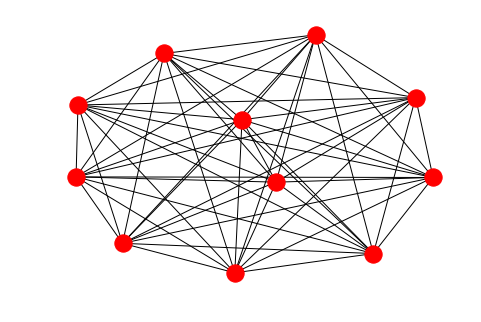

In [21]:
import ssdeep
import networkx as nx
import matplotlib.pyplot as plt

G   = nx.Graph()
ss  = sqlCtx.sql("SELECT infos.sha1, infos.ssdeep FROM malwares")
lss = ss.collect()

for s1 in range(len(lss)):
    for s2 in range(s1+1, len(lss)):
        rate = ssdeep.compare(lss[s1]['ssdeep'], lss[s2]['ssdeep'])
        if rate > 0:
            G.add_edge(lss[s1]['sha1'], lss[s2]['sha1'])
            G.add_weighted_edges_from([(lss[s1]['sha1'], lss[s2]['sha1'], rate)])
nx.draw(G)
plt.show()

n_sub_graphs = nx.number_connected_components(G)
sub_graphs   = nx.connected_component_subgraphs(G)
for i, sub_graph in enumerate(sub_graphs):
    n_nodes = len(sub_graph.nodes())
    if n_nodes >= 10:    # 找出相似度大于5个节点的PE文件
        print ("Subgraph {0} has {1} nodes {2}".format(i, n_nodes, sub_graph.nodes()))
        nx.draw(sub_graph)
        plt.show()

In [ ]:
# Neo4j例子
from neo4j.v1 import GraphDatabase, basic_auth 
driver  = GraphDatabase.driver("bolt://127.0.0.1:7687", auth=basic_auth("wunianjing89@gmail.com", "Nj727719"))
session = driver.session()

ss      = sqlCtx.sql("SELECT infos.sha1, infos.ssdeep, peid_signature, pe_imphash, pe_filename FROM malwares")
lss     = ss.collect()

insert = """
UNWIND {pairs} as pair
MERGE (pe1:PESST {filename:pair[0], ssdeep:pair[1], sha1:pair[2]})
MERGE (pe2:PESST {filename:pair[3], ssdeep:pair[4], sha1:pair[5]})
MERGE (pe1)-[r:Similar {ssdeep:pair[6]}]-(pe2);
"""
length = len(lss)

for s1 in range(length):
    for s2 in range(s1+1,length):
        rate = ssdeep.compare(lss[s1]["ssdeep"], lss[s2]["ssdeep"])
        if rate > 0:
            p = [["_"+lss[s1]['pe_filename'].replace(".", "_"), lss[s1]['ssdeep'] , lss[s1]['sha1'], "_"+lss[s2]['pe_filename'].replace(".", "_"), lss[s2]['ssdeep'], lss[s2]['sha1'] ,c]]
            session.run(insert, parameters={"pairs":p})